# Predicting Doctor Appointment No-Shows
***

## Table of Contents
* [Introduction](#introduction)
* [Data Wrangling](#data_wrangling)
    * [General Properties](#general_properties)
    * [Data Cleaning](#data_cleaning)
        * [Checking for Duplicates](#cleaning_duplicates)
        * [Appointment ID](#cleaning_appointment_id)
        * [Scheduled Day](#cleaning_scheduled_day)
        * [Appointment Day](#cleaning_appointment_day)
        * [Gender](#cleaning_gender)
        * [Age](#cleaning_age)
        * [Bolsa Familia](#cleaning_bolsa_familia)
        * [Hypertension](#cleaning_hypertension)
        * [Diabetes](#cleaning_diabetes)
        * [Number of Handicaps](#cleaning_number_handicaps)
        * [SMS Received](#cleaning_sms_received)
        * [No Show](#cleaning_no_show)
        * [Neighborhood](#cleaning_neighborhood)
        * [Patient ID](#cleaning_patient_id)
            * [Patient ID Consistency](#cleaning_patient_id_consistency)
* [Additional Data](#addtl_data)
* [Feature Engineering](#feat_engineering)
* [Exploratory Data Analysis](#eda)
    * [Initial Exploration and Further Cleaning](#further_cleaning)
    * [Univariate Plots and Analysis](#univariate)

<a id='introduction'></a>

## Introduction
***

In this project, my aim is to determine what patient characteristics are connected with not showing up to a doctor's appointment by analyzing a data set of over 110K medical appointments in Vitória, Espírito Santo, Brazil provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

<a id='data_wrangling'></a>

## Data Wrangling
***

In [1]:
import pandas as pd
import numpy as np
import geocoder
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import config
API_KEY = config.api_key

<a id='general_properties'></a>

### General Properties

In [2]:
orig = pd.read_csv('KaggleV2-May-2016.csv')
orig.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Number of records
n = len(orig)
n

110527

In [4]:
# Rename fields to have more consistent formatting and to English where appropriate
orig.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
              'AppointmentDay', 'Age', 'Neighborhood', 'BolsaFamilia', \
              'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps', \
              'SMSReceived', 'NoShow']

In [5]:
# Number of nulls
orig.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighborhood      0
BolsaFamilia      0
Hypertension      0
Diabetes          0
Alcoholism        0
NumHandicaps      0
SMSReceived       0
NoShow            0
dtype: int64

> There are no null records in any of the fields

In [6]:
# Data types
orig.dtypes

PatientID         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighborhood       object
BolsaFamilia        int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
NumHandicaps        int64
SMSReceived         int64
NoShow             object
dtype: object

<a id='data_cleaning'></a>

### Data Cleaning

<a id='cleaning_duplicates'></a>

#### Checking for Duplicates

In [7]:
orig.duplicated(keep=False).any()

False

In [8]:
orig.duplicated('AppointmentID', keep=False).any()

False

> There are no duplicate entries and no duplicate AppointmentIDs.

<a id='cleaning_appointment_id'></a>

#### Appointment ID

In [9]:
min_apptID = orig['AppointmentID'].min()
max_apptID = orig['AppointmentID'].max()
print('{} - {}'.format(min_apptID, max_apptID))

5030230 - 5790484


> All of the appointment IDs are 7 digits long, and are between these values

In [10]:
# AppointmentIDs are identifiers, so they are also converted to strings
orig['AppointmentID'] = orig['AppointmentID'].astype(str)

<a id='cleaning_scheduled_day'></a>

#### Scheduled Day
ScheduledDay represents the day that a patient created the appointment.

In [11]:
# Convert the scheduled day to a datetime
orig['ScheduledDay'] = pd.to_datetime(orig['ScheduledDay'])

# Verify that ScheduledDay is in a datetime format
orig['ScheduledDay'].dtype

dtype('<M8[ns]')

In [12]:
# Check that the <M8[ns] is a datetime format
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [13]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['ScheduledDay']).sum()

0

In [14]:
# Include a field for scheduled day in a date format
orig['ScheduledDayDate'] = orig['ScheduledDay'].dt.date

In [15]:
# The first date and time an appointment was scheduled 
np.min(orig['ScheduledDay'])

Timestamp('2015-11-10 07:13:56')

In [16]:
# The last date and time an appointment was scheduled 
np.max(orig['ScheduledDay'])

Timestamp('2016-06-08 20:07:23')

In [17]:
np.max(orig['ScheduledDay']) - np.min(orig['ScheduledDay'])

Timedelta('211 days 12:53:27')

> All appointments are created within an about 7-month time frame.

<a id='cleaning_appointment_day'></a>

#### Appointment Day
AppointmentDay is the day of the doctor's appointment.

In [18]:
# Convert the appointment day to a datetime
orig['AppointmentDay'] = pd.to_datetime(orig['AppointmentDay'])

# Verify that AppointmentDay is in a datetime format
orig['AppointmentDay'].dtype

dtype('<M8[ns]')

In [19]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['AppointmentDay']).sum()

0

In [20]:
# Since appointment day doesn't have a time, include another field for 
# it in a date format
orig['AppointmentDayDate'] = orig['AppointmentDay'].dt.date

# The first scheduled appointment
np.min(orig['AppointmentDay'])

Timestamp('2016-04-29 00:00:00')

In [21]:
# The last scheduled appointment
np.max(orig['AppointmentDay'])

Timestamp('2016-06-08 00:00:00')

In [22]:
np.max(orig['AppointmentDay']) - np.min(orig['AppointmentDay'])

Timedelta('40 days 00:00:00')

> While the appointments were scheduled during a 7-month period, they all were scheduled for a 40-day period.

<a id='cleaning_gender'></a>

#### Gender

In [23]:
# Gender data is clean
orig['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [24]:
# Encode gender as binary, 0 = male, 1 = female 
orig['Gender'] = np.where(orig['Gender'].values == 'F', 1, 0)
orig['Gender'].value_counts()

1    71840
0    38687
Name: Gender, dtype: int64

<a id='cleaning_age'></a>

#### Age

In [25]:
age_counts = orig['Age'].value_counts()
age_counts.index.sort_values()

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
             93,  94,  95,  96,  97,  98,  99, 100, 102, 115],
           dtype='int64', length=104)

In [26]:
# Drop the record with an age of -1
invalid_age = orig[orig['Age'] == -1]['PatientID']
orig.drop(invalid_age.index, inplace=True)

> I removed the record with the age of -1.  All of the other ages are plausible; although the age of 115 is improbable, it is still possible.

<a id='cleaning_bolsa_familia'></a>

#### Bolsa Família

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program in Brazil.  A value of 1 for this field means that the patient receives financial aid from the Brazilian government under this progrm.

In [27]:
# BolsaFamilia data is clean
orig['BolsaFamilia'].value_counts()

0    99665
1    10861
Name: BolsaFamilia, dtype: int64

<a id='cleaning_hypertension'></a>

#### Hypertension

In [28]:
# Hypertension data is clean
orig['Hypertension'].value_counts()

0    88725
1    21801
Name: Hypertension, dtype: int64

<a id='cleaning_diabetes'></a>

#### Diabetes

In [29]:
# Diabetes data is clean
orig['Diabetes'].value_counts()

0    102583
1      7943
Name: Diabetes, dtype: int64

<a id='cleaning_alcoholism'></a>

#### Alcholism

In [30]:
# Alcoholism data is clean
orig['Alcoholism'].value_counts()

0    107166
1      3360
Name: Alcoholism, dtype: int64

<a id='cleaning_number_handicaps'></a>

#### Number of Handicaps

In [31]:
# This represents the number of handicaps a person has (as defined by the publisher of the dataset)
# All people having between 0-4 handicaps seems reasonable
orig['NumHandicaps'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: NumHandicaps, dtype: int64

<a id='cleaning_sms_received'></a>

#### SMS Received
This field indicates whether or not a patient was sent an appointment reminder by the facility in the form of a text message.

In [32]:
# SMS Received data is clean
orig['SMSReceived'].value_counts()

0    75044
1    35482
Name: SMSReceived, dtype: int64

<a id='cleaning_no_show'></a>

#### No Show

A value of yes for NoShow means that the patient did not show up to their appointment (they were a 'no show').

In [33]:
orig['NoShow'].value_counts()

No     88207
Yes    22319
Name: NoShow, dtype: int64

In [34]:
# Convert NoShow to zeros and ones
orig['NoShow'] = np.where(orig['NoShow'].values == 'Yes', 1, 0)
orig['NoShow'].value_counts()

0    88207
1    22319
Name: NoShow, dtype: int64

<a id='cleaning_neighborhood'></a>

#### Neighborhood

The Neighborhood field has the neighborhood of the doctor's facility.

In [35]:
neighborhood_counts = orig['Neighborhood'].value_counts()
neighborhood_counts[:11]

JARDIM CAMBURI       7717
MARIA ORTIZ          5805
RESISTÊNCIA          4431
JARDIM DA PENHA      3877
ITARARÉ              3514
CENTRO               3334
TABUAZEIRO           3132
SANTA MARTHA         3131
JESUS DE NAZARETH    2853
BONFIM               2773
SANTO ANTÔNIO        2746
Name: Neighborhood, dtype: int64

In [36]:
# Number of unique neighborhoods
orig['Neighborhood'].nunique()

81

In [37]:
# Organize the neighborhoods into a dataframe
geo = pd.DataFrame(neighborhood_counts.index, columns = ['neighborhood'])
geo.head()

,neighborhood
0,JARDIM CAMBURI
1,MARIA ORTIZ
2,RESISTÊNCIA
3,JARDIM DA PENHA
4,ITARARÉ


In [38]:
# Geocode the neighborhood data
"""
for i, row in geo.iterrows():
    # Use Bing    
    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'
    result = geocoder.bing(full_neighborhood, key=API_KEY)
    
    geo.at[i, 'status'] = result.status
    geo.at[i, 'lat'] = result.lat
    geo.at[i, 'lng'] = result.lng
    geo.at[i, 'bing_neighborhood'] = result.neighborhood
    geo.at[i, 'city'] = result.city
    geo.at[i, 'state'] = result.state
    geo.at[i, 'country'] = result.country
    
    # If Bing returns None for neighborhood, use Google
    if geo.loc[i, 'bing_neighborhood'] is None:
        result = geocoder.google(full_neighborhood)
        
        geo.at[i, 'status'] = result.status
        geo.at[i, 'lat'] = result.lat
        geo.at[i, 'lng'] = result.lng
        
        if result.county == 'Vitória': # Google uses county when Bing uses city
            geo.at[i, 'city'] = result.county
        geo.at[i, 'state'] = result.state
        if result.country == 'BR':
            geo.at[i, 'country'] = 'Brazil'
"""

"\nfor i, row in geo.iterrows():\n    # Use Bing    \n    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'\n    result = geocoder.bing(full_neighborhood, key=API_KEY)\n    \n    geo.at[i, 'status'] = result.status\n    geo.at[i, 'lat'] = result.lat\n    geo.at[i, 'lng'] = result.lng\n    geo.at[i, 'bing_neighborhood'] = result.neighborhood\n    geo.at[i, 'city'] = result.city\n    geo.at[i, 'state'] = result.state\n    geo.at[i, 'country'] = result.country\n    \n    # If Bing returns None for neighborhood, use Google\n    if geo.loc[i, 'bing_neighborhood'] is None:\n        result = geocoder.google(full_neighborhood)\n        \n        geo.at[i, 'status'] = result.status\n        geo.at[i, 'lat'] = result.lat\n        geo.at[i, 'lng'] = result.lng\n        \n        if result.county == 'Vitória': # Google uses county when Bing uses city\n            geo.at[i, 'city'] = result.county\n        geo.at[i, 'state'] = result.state\n        if result.country == 'BR':

In [39]:
#geo.head()

In [40]:
# Check that all the neighborhoods are unique
#(geo['bing_neighborhood'].value_counts() == 1).all()

In [41]:
# Check that each neighborhood returns a unique location
#not any(geo.duplicated(['lat', 'lng']))

In [42]:
# Verify that all of the locations are in Vitória, Espírito Santo, Brazil
#print((geo['status'] == 'OK').all())
#print((geo['city'] == 'Vitória').all())
#print((geo['state'] == 'ES').all())
#print((geo['country'] == 'Brazil').all())

<a id='cleaning_patient_id'></a>

#### Patient ID

In [43]:
# Convert patient ID to a string, as it is meant to be an identifier not a number
orig['PatientID'] = orig['PatientID'].astype(int).astype(str)

# All identifiers are 7-15 digits long, most have at least 10
lens = orig['PatientID'].apply(len)
pd.value_counts(lens)

14    39372
13    28319
15    24918
12    12835
11     4002
10      920
9       136
8        18
5         3
6         2
7         1
Name: PatientID, dtype: int64

> Most of the patient IDs are at least 10 digits long.  There is no consistent length for this field, and it is unknown, and impossible to know, if some of these patient identifiers are flawed.  It is an identifier and does not need to be operated on or with, therefore none of these records will be removed.

<a id='cleaning_patient_id_consistency'></a>

##### PatientID Consistency

In [44]:
# Number of appointments per PatientID
num_appts_by_patient = orig.groupby('PatientID')['AppointmentID'].count()
num_appts_by_patient[:5]

PatientID
11111462625267     1
111124532532143    2
11114485119737     1
11116239871275     1
1111633122891      3
Name: AppointmentID, dtype: int64

There are multiple appointments for some patients, so I am checking that the information for each patient across the different appointments is the same.

In [45]:
# All have the same gender
unique_gender_vals = orig.groupby('PatientID')['Gender'].nunique()
len(unique_gender_vals[unique_gender_vals > 1])

0

In [46]:
# All have the same BolsaFamilia status
unique_bf_vals = orig.groupby('PatientID')['BolsaFamilia'].nunique()
len(unique_bf_vals[unique_bf_vals > 1])

0

In [47]:
# All have the same value for Hypertension
unique_hypertension_vals = orig.groupby('PatientID')['Hypertension'].nunique()
len(unique_hypertension_vals[unique_hypertension_vals > 1])

0

In [48]:
# All have the same value for Diabetes
unique_diabetes_vals = orig.groupby('PatientID')['Diabetes'].nunique()
len(unique_diabetes_vals[unique_diabetes_vals > 1])

0

In [49]:
# All have the same value for Alcoholism
unique_alcoholism_vals = orig.groupby('PatientID')['Alcoholism'].nunique()
len(unique_alcoholism_vals[unique_alcoholism_vals > 1])

0

In [50]:
# All have the same value for NumHandicaps
unique_handicaps_vals = orig.groupby('PatientID')['NumHandicaps'].nunique()
len(unique_handicaps_vals[unique_handicaps_vals > 1])

0

In [51]:
# All have the same value for Neighborhood - so patients kept the same doctor's office/hospital
unique_neighborhood_vals = orig.groupby('PatientID')['Neighborhood'].nunique()
len(unique_neighborhood_vals[unique_neighborhood_vals > 1])

0

In [52]:
# Appointments occur with a 7-month period, so the entries for a patient's ages should be within a year of each other
unique_age_vals = orig.groupby('PatientID')['Age'].nunique()
not_unique_age_vals = unique_age_vals[unique_age_vals > 1]

# Patients with more than one appointment, all have less than 2 values for age
len(not_unique_age_vals[not_unique_age_vals > 2])

0

In [53]:
# Get the information for the patients with more than one age
patients_multiple_ages = list(not_unique_age_vals.index)
multiple_ages_info = orig[orig['PatientID'].isin(patients_multiple_ages)].sort_values('PatientID')
multiple_ages_info.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow,ScheduledDayDate,AppointmentDayDate
3850,112114682124172,5490237,1,2016-03-18 14:26:03,2016-05-02,0,RESISTÊNCIA,0,0,0,0,0,1,1,2016-03-18,2016-05-02
110232,112114682124172,5676082,1,2016-05-09 14:56:13,2016-06-08,1,RESISTÊNCIA,0,0,0,0,0,1,1,2016-05-09,2016-06-08
10283,11238367556569,5723118,1,2016-05-20 07:58:35,2016-05-20,29,ROMÃO,0,1,0,0,0,0,0,2016-05-20,2016-05-20
19089,11238367556569,5675794,1,2016-05-09 14:21:41,2016-05-13,28,ROMÃO,0,1,0,0,0,0,0,2016-05-09,2016-05-13
19091,11238367556569,5675795,1,2016-05-09 14:21:41,2016-05-13,28,ROMÃO,0,1,0,0,0,0,0,2016-05-09,2016-05-13


In [54]:
# Get the difference between each patient's ages
max_age = multiple_ages_info.groupby('PatientID')['Age'].max()
min_age = multiple_ages_info.groupby('PatientID')['Age'].min()
age_diff = max_age - min_age
age_diff.head()

PatientID
112114682124172    1
11238367556569     1
1124242331227      1
1126541547466      1
112777857389857    1
Name: Age, dtype: int64

In [55]:
# Each patient's ages are within one year of each other
age_diff[age_diff <= 1].all()

True

<a id='addtl_data'></a>

## Additional Data
***

I obtained weather data for Vitória airport from [wunderground.com](https://www.wunderground.com/history/airport/SBVT/2016/4/29/DailyHistory.html) for the appointment dates.

In [56]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
weather.head()

,Date,temp_high,temp_avg,temp_low,humidity_high,humidity_avg,humidity_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog
0,2016-04-29,75,73,71,88,76,64,12,7,6,16,11,0.01,0,0,0
1,2016-04-30,80,74,69,88,79,70,12,7,6,13,7,0.00,0,0,0
2,2016-05-01,77,73,69,83,67,52,12,6,4,17,13,0.00,1,0,0
3,2016-05-02,81,74,66,83,58,33,12,8,6,17,11,0.00,0,0,0
4,2016-05-03,79,70,62,88,80,61,12,7,6,17,5,0.00,0,0,0


In [57]:
all(weather['visibility_high'] == 12)

True

In [58]:
# Remove the visibility_high field since it has the same value for every date
weather.drop('visibility_high', axis=1, inplace=True)

# Merge appointment data with weather data
ow = pd.merge(orig, weather, left_on='AppointmentDayDate', right_on='Date', how='left')

# Check there are no null values
all(ow.isnull().sum() == 0)

True

<a id='feat_engineering'></a>

## Feature Engineering
***

### Differences Between Scheduled and Appointment Days

In [59]:
# Add a field for the number of days between scheduling and the appointment
ow['DayDiff'] = ((ow['AppointmentDayDate'] - ow['ScheduledDayDate'])/np.timedelta64(1, 'D')).astype(int)
ow[['ScheduledDayDate', 'AppointmentDayDate', 'DayDiff']].sort_values(by = 'DayDiff')[:7]

,ScheduledDayDate,AppointmentDayDate,DayDiff
71533,2016-05-11,2016-05-05,-6
72362,2016-05-04,2016-05-03,-1
64175,2016-05-05,2016-05-04,-1
55226,2016-05-18,2016-05-17,-1
27033,2016-05-10,2016-05-09,-1
57785,2016-05-04,2016-05-04,0
57786,2016-05-18,2016-05-18,0


We can see that we need to do some data cleaning as there are five appointments that were shown to be scheduled days after the appointment itself.  These are obviously errors and since there are only five, they were removed from the data.

In [60]:
ow = (ow[ow['DayDiff'] >= 0])

### Day of Week and Weekend

In [61]:
# Add a field for whether the AppointmentDay is during the weekend (1) or not (0)
ow['Day_of_Week'] = pd.to_datetime(ow['AppointmentDay']).dt.dayofweek
ow['Weekend'] = np.where(ow['Day_of_Week'] >= 5, 1, 0)

# Number of weekend appointments
ow['Weekend'].sum()

39

<a id='eda'></a>

## Exploratory Data Analysis
***

<a id='further_cleaning'></a>

### Initial Exploration and Further Cleaning

#### Number of appointments by patient

In [62]:
num_appts_by_patient.sort_values(ascending = False)[:10]

PatientID
822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
75797461494159     62
258424392677       62
871374938638855    62
6264198675331      62
66844879846766     57
872278549442       55
Name: AppointmentID, dtype: int64

> Oddly there are patients with a significant number of appointments.  The appointments only occurred during a 40-day period, so even if a patient had an appointment every day during this period, they would still only have a maximum of 40 appointments.

In [63]:
# Bin the number of appointments per patient
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 80]
bin_names = ["1", "2", "3", "4", "5", "6-10", "11-15", "16-20", "21-30", "31-40", "41-50", "50+"]

num_appts_binned = pd.cut(num_appts_by_patient, bins = bins, labels = bin_names).value_counts()
num_appts_binned.sort_index()

1        37919
2        13895
3         5500
4         2367
5         1119
6-10      1250
11-15      171
16-20       42
21-30       10
31-40        8
41-50        5
50+         10
Name: AppointmentID, dtype: int64

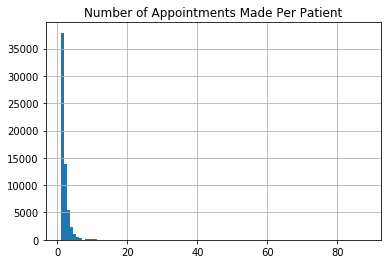

In [64]:
num_appts_by_patient.hist(bins = 100)
plt.title("Number of Appointments Made Per Patient");

The number of appointments is very skewed to the right.  The majority of patients made three or fewer appointments during this 40-day time period, but the data is very long tailed with upto 88 appointments per patient.

In [65]:
# Inspect the patient with 88 appointments
most_appts = ow[ow['PatientID'] == '822145925426128'].sort_values(by = 'ScheduledDay')
most_appts

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,Day_of_Week,Weekend
3006,822145925426128,5638995,0,2016-04-29 08:38:44,2016-04-29,38,REDENÇÃO,0,0,0,...,6,16,11,0.01,0,0,0,0,4,0
3093,822145925426128,5640809,0,2016-04-29 11:27:34,2016-04-29,38,REDENÇÃO,0,0,0,...,6,16,11,0.01,0,0,0,0,4,0
3060,822145925426128,5642878,0,2016-04-29 18:02:42,2016-04-29,38,REDENÇÃO,0,0,0,...,6,16,11,0.01,0,0,0,0,4,0
8707,822145925426128,5645183,0,2016-05-02 09:34:46,2016-05-02,38,REDENÇÃO,0,0,0,...,6,17,11,0.00,0,0,0,0,0,0
25428,822145925426128,5649058,0,2016-05-02 17:38:17,2016-05-02,38,REDENÇÃO,0,0,0,...,6,17,11,0.00,0,0,0,0,0,0
35675,822145925426128,5649163,0,2016-05-02 17:57:36,2016-05-02,38,REDENÇÃO,0,0,0,...,6,17,11,0.00,0,0,0,0,0,0
7685,822145925426128,5655382,0,2016-05-03 16:57:59,2016-05-03,38,REDENÇÃO,0,0,0,...,6,17,5,0.00,0,0,0,0,1,0
8831,822145925426128,5657205,0,2016-05-04 09:03:31,2016-05-04,38,REDENÇÃO,0,0,0,...,6,15,5,0.00,0,0,0,0,2,0
8450,822145925426128,5658723,0,2016-05-04 11:38:34,2016-05-04,38,REDENÇÃO,0,0,0,...,6,15,5,0.00,0,0,0,0,2,0
8465,822145925426128,5658733,0,2016-05-04 11:40:14,2016-05-04,38,REDENÇÃO,0,0,0,...,6,15,5,0.00,0,0,0,0,2,0


In [66]:
most_appts['NoShow'].sum()

1

> From analyzing this and other patients' appointments, I found that many appointments were made for a certain day, and then later another appointment was made for that same day.  We can see above that the patient made an appointment for April 29, three different times.  For the patient above, they made the appointments within farily quick succession of each other.  However other patients, as shown below, seemed to make appointments in advance and then as the appointment got closer rescheduled it.

In [67]:
ow[ow['PatientID'] == '99992299798515'].sort_values(by = 'ScheduledDay')

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,Day_of_Week,Weekend
51445,99992299798515,5599070,1,2016-04-19 08:25:12,2016-05-02,35,PIEDADE,1,1,0,...,6,17,11,0.0,0,0,0,13,0,0
50445,99992299798515,5648376,1,2016-05-02 15:33:59,2016-05-02,35,PIEDADE,1,1,0,...,6,17,11,0.0,0,0,0,0,0,0


In [68]:
ow[ow['PatientID'] == '111415561531417'].sort_values(by = 'ScheduledDay').iloc[:, :14]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow
105562,111415561531417,5657853,1,2016-05-04 10:02:43,2016-06-06,45,SANTA MARTHA,0,0,0,0,0,1,1
18225,111415561531417,5657892,1,2016-05-04 10:06:30,2016-05-13,45,SANTA MARTHA,0,0,0,0,0,0,0
103283,111415561531417,5721379,1,2016-05-19 16:13:52,2016-06-06,45,SANTA MARTHA,0,0,0,0,0,0,1
105716,111415561531417,5747599,1,2016-05-30 15:55:49,2016-06-03,45,SANTA MARTHA,0,0,0,0,0,1,0


In the case above, the patient made an appointment for June 6, and on the same day makes an appoitment for May 13.  Then 15 days later makes another appointment for/reschedules the June 6 appointment.  Finally they make another appointment for three days before their scheduled appointment.  I would guess that they rescheduled their appointment for an earlier day, so it may be illogical to term their non-attendance as a "no show."  Unfortunately this is just a hypothesis, and since there is neither extra data, nor an explanation for the multiple appointments, this cannot be confirmed.  If more information later became available this aspect of the data could possibly be addressed.

To address the issue of multiple appointments made for the same day, I made the decision to only keep the last appointment made on the same day as an already made appointment.  Although records were removed, this data was preserved in the extra fields of the number of times the appointment for that day was scheduled and the time difference between the first and last scheduling.

In [69]:
# Sort the dataframe and update the index, so that the records are in
# order of when they were made
ow = ow.sort_values(by = ['PatientID', 'ScheduledDay', 'AppointmentDay'])
ow.index = range(1,len(ow) + 1)
ow.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,Day_of_Week,Weekend
1,11111462625267,5715720,1,2016-05-18 14:58:29,2016-06-08,65,REPÚBLICA,0,1,0,...,6,16,9,0.04,1,0,0,21,2,0
2,111124532532143,5531224,0,2016-03-31 09:17:26,2016-05-03,9,MARIA ORTIZ,0,0,0,...,6,17,5,0.00,0,0,0,33,1,0
3,111124532532143,5624030,0,2016-04-26 15:05:58,2016-06-01,9,MARIA ORTIZ,0,0,0,...,6,13,4,0.01,0,1,0,36,2,0
4,11114485119737,5621757,1,2016-04-26 10:46:38,2016-05-25,12,MARIA ORTIZ,0,0,0,...,6,16,12,0.00,0,0,0,29,2,0
5,11116239871275,5625265,1,2016-04-27 07:05:38,2016-04-29,13,SÃO PEDRO,0,0,0,...,6,16,11,0.01,0,0,0,2,4,0


In [70]:
# Aggregate data by PatientID and AppointmentDay, and assemble all the AppointmentIDs associated
# with them into a tuple
df_appt_id_list = ow.groupby(['PatientID', 'AppointmentDay'], as_index=False)['AppointmentID']. \
                apply(tuple).reset_index()
df_appt_id_list.columns = ['PatientID', 'AppointmentDay', 'AppointmentIDList']
df_appt_id_list.head()

,PatientID,AppointmentDay,AppointmentIDList
0,11111462625267,2016-06-08,"(5715720,)"
1,111124532532143,2016-05-03,"(5531224,)"
2,111124532532143,2016-06-01,"(5624030,)"
3,11114485119737,2016-05-25,"(5621757,)"
4,11116239871275,2016-04-29,"(5625265,)"


In [71]:
# Create field for the last appointment created for that date
df_appt_id_list['LastAppt'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: x[len(x) - 1])

# Create field for the number of times that appointment was scheduled
df_appt_id_list['NumTimesScheduled'] = df_appt_id_list['AppointmentIDList'].apply(len)

df_appt_id_list[25:30]

,PatientID,AppointmentDay,AppointmentIDList,LastAppt,NumTimesScheduled
25,11137679822,2016-06-07,"(5782983,)",5782983,1
26,111415561531417,2016-05-13,"(5657892,)",5657892,1
27,111415561531417,2016-06-03,"(5747599,)",5747599,1
28,111415561531417,2016-06-06,"(5657853, 5721379)",5721379,2
29,1114298941257,2016-05-24,"(5729946,)",5729946,1


In [72]:
# Create function for looking up the time difference between
# the ScheduledDay for the appointments that have more than one ID
# else the difference is 0
def get_days_bw_scheduling(x, df):
    if len(x) == 1:
        return pd.Timedelta(0)
    else:
        first_sch = df[df['AppointmentID'] == x[0]].iloc[0, 3] # first scheduling
        last_sch = df[df['AppointmentID'] == x[len(x) - 1]].iloc[0, 3] # last scheduling
        return last_sch - first_sch

In [73]:
df_appt_id_list['DaysBWScheduling'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: get_days_bw_scheduling(x, ow))

In [74]:
# Merge this data with the original dataframe
df = pd.merge(ow, df_appt_id_list, left_on = ['PatientID', 'AppointmentDay', 'AppointmentID'], 
              right_on = ['PatientID', 'AppointmentDay', 'LastAppt'])

# Remove unnecessary and redundant columns
df.drop(['AppointmentIDList', 'LastAppt'], axis = 1, inplace = True)
df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,Day_of_Week,Weekend,NumTimesScheduled,DaysBWScheduling
0,11111462625267,5715720,1,2016-05-18 14:58:29,2016-06-08,65,REPÚBLICA,0,1,0,...,9,0.04,1,0,0,21,2,0,1,0 days
1,111124532532143,5531224,0,2016-03-31 09:17:26,2016-05-03,9,MARIA ORTIZ,0,0,0,...,5,0.00,0,0,0,33,1,0,1,0 days
2,111124532532143,5624030,0,2016-04-26 15:05:58,2016-06-01,9,MARIA ORTIZ,0,0,0,...,4,0.01,0,1,0,36,2,0,1,0 days
3,11114485119737,5621757,1,2016-04-26 10:46:38,2016-05-25,12,MARIA ORTIZ,0,0,0,...,12,0.00,0,0,0,29,2,0,1,0 days
4,11116239871275,5625265,1,2016-04-27 07:05:38,2016-04-29,13,SÃO PEDRO,0,0,0,...,11,0.01,0,0,0,2,4,0,1,0 days


In [76]:
len(ow) - len(df)

8718

> Note that 8718 records that represented the extra appointments made all on the same day were removed from the data.

<a id='univariate'></a>

### Univariate Plots and Analysis

In [92]:
# Number of records in the cleaned dataset
len(df)

101803

#### Patient Characteristics

In [251]:
# Get unique patients when getting frequency of patient characteristics
unique_patients = df.groupby('PatientID').first()
len(unique_patients)

62298

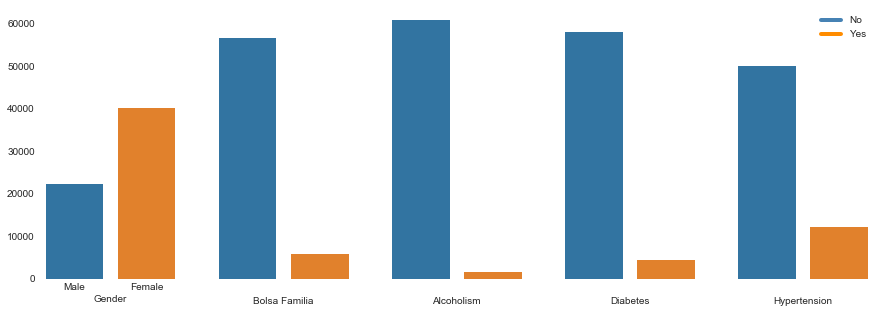

In [95]:
# Plot binary patient characteristics
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['', ''])
        ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [136]:
fields = ['Women', 'Bolsa Familia', 'Alcoholic', 'Diabetes', 'Hypertension']
stats = [round(unique_patients['Gender'].mean(), 3),
         round(unique_patients['BolsaFamilia'].mean(), 3),
         round(unique_patients['Alcoholism'].mean(), 3),
         round(unique_patients['Diabetes'].mean(), 3),
         round(unique_patients['Hypertension'].mean(), 3)]

pd.DataFrame(stats, index = fields, columns = ['Proportion'])

,Proportion
Women,0.643
Bolsa Familia,0.093
Alcoholic,0.024
Diabetes,0.071
Hypertension,0.197


In [111]:
# Average number of appointments per patient
round(df.groupby('PatientID')['AppointmentID'].count().mean(), 2)

1.63

#### Age

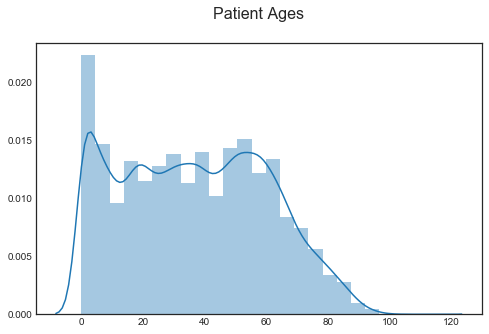

In [80]:
# Only plot the first age for each unique patient that appears in the dataset
fig = plt.figure(figsize = (8, 5))
sns.distplot(unique_patients['Age'], bins = 25)
plt.title('Patient Ages\n', fontsize = 16)
plt.xlabel('')
plt.show();

In [178]:
bins = [0, 11, 21, 41, 61, 81, 100, 116]
bin_names = ["0-10", "11-20", "21-40", "41-60", "61-80", "81-99", "100+"]

ages_bins = pd.cut(unique_patients['Age'], bins = bins, labels = bin_names).value_counts()
ages_bins.sort_index()

0-10      9951
11-20     7613
21-40    15647
41-60    16459
61-80     9118
81-99     1435
100+         4
Name: Age, dtype: int64

In [82]:
df['Age'].describe()

count    101803.000000
mean         37.059900
std          23.214054
min           0.000000
25%          18.000000
50%          37.000000
75%          56.000000
max         115.000000
Name: Age, dtype: float64

#### Number of Handicaps

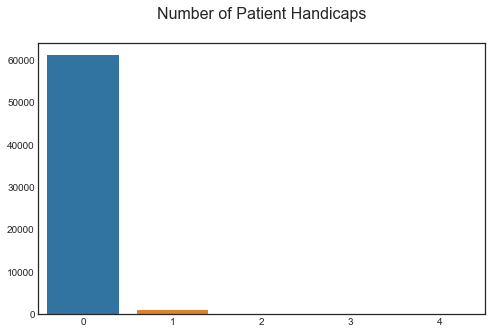

In [83]:
fig = plt.figure(figsize = (8, 5))
sns.countplot(unique_patients['NumHandicaps'])
plt.title('Number of Patient Handicaps\n', fontsize = 16)
plt.xlabel('')
plt.ylabel('')
plt.show();

In [84]:
unique_patients['NumHandicaps'].value_counts()

0    61165
1     1025
2       99
3        6
4        3
Name: NumHandicaps, dtype: int64

In [85]:
round(unique_patients['NumHandicaps'].mean(), 3)

0.020113005232912776

#### Appointments by Day

In [86]:
df['AppointmentDay'].value_counts().sort_index().resample('D').sum()

2016-04-29    2979
2016-04-30       0
2016-05-01       0
2016-05-02    4056
2016-05-03    3960
2016-05-04    3828
2016-05-05    3984
2016-05-06    3535
2016-05-07       0
2016-05-08       0
2016-05-09    4164
2016-05-10    3960
2016-05-11    4162
2016-05-12    4083
2016-05-13    3568
2016-05-14      38
2016-05-15       0
2016-05-16    4238
2016-05-17    4069
2016-05-18    4029
2016-05-19    3931
2016-05-20    3484
2016-05-21       0
2016-05-22       0
2016-05-23       0
2016-05-24    3692
2016-05-25    3566
2016-05-26       0
2016-05-27       0
2016-05-28       0
2016-05-29       0
2016-05-30    4139
2016-05-31    3956
2016-06-01    4088
2016-06-02    4014
2016-06-03    3766
2016-06-04       0
2016-06-05       0
2016-06-06    4300
2016-06-07    4098
2016-06-08    4116
Freq: D, Name: AppointmentDay, dtype: int64

There were only 38 appointments on the weekend, all occurring on Saturday, May 14th.  Besides the weekends, there were no appointments on Monday, May 23; Thursday, May 26; or Friday, May 27.

May 26 was the optional holiday of Corpus Christi, however I couldn't find any reason as to why there is no data for the 23rd or 27th.

In [87]:
df['Weekend'].sum()

38

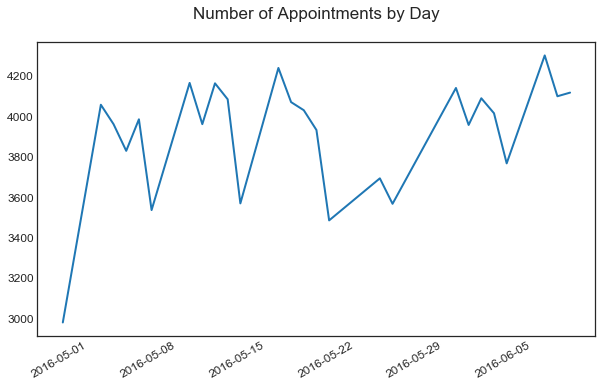

In [88]:
# Exclude weekends and weekdays with no appointments
fig = plt.figure(figsize = (10, 6))
no_weekends = df[df['Weekend'] == 0]
appt_by_day = no_weekends.groupby('AppointmentDay')['AppointmentDay'].count()
appt_by_day.plot(fontsize = 12, linewidth = 2)
plt.title('Number of Appointments by Day\n', fontsize = 17)
plt.xlabel('');

The weekends and weekdays with no appointments were excluded from the graph in order to focus more on the normal fluctuations without the low outliers affecting the graph.

In [106]:
# Average number of appointments per day (on non-zero days and weekdays)
round(df[df['Weekend'] == 0]['AppointmentDay'].value_counts().mean(), 2)

3914.04

#### Scheduled Appointments By Day

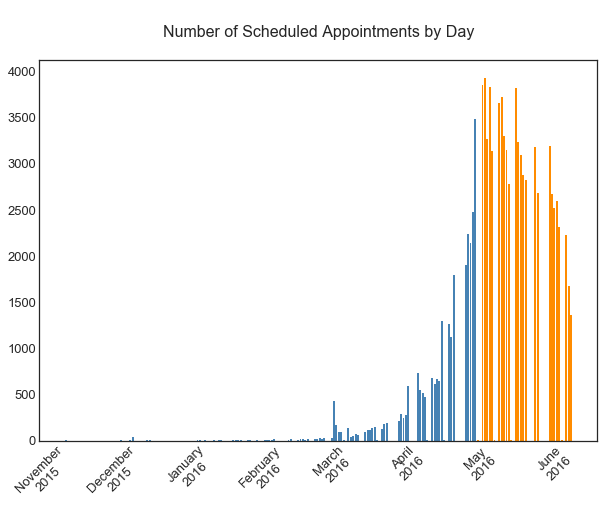

In [246]:
sched_date_counts = df.groupby('ScheduledDayDate')['ScheduledDayDate'].count()

# Find index of first scheduled date that is an appointment date
sched_len = len(sched_date_counts)
first_ix = list(sched_date_counts.index > df['AppointmentDayDate'].min()).index(True)

# Use orange for the appointments scheduled during the time period that
# the appointments took place
colors = ['steelblue'] * first_ix
colors.extend(['darkorange'] * (sched_len-first_ix))

fig, ax = plt.subplots(figsize = (10, 7))
ax.bar(sched_date_counts.index, sched_date_counts, color = colors)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B\n%Y'))
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('\nNumber of Scheduled Appointments by Day\n', fontsize = 16);

In [253]:
# Proportion of appointments that were scheduled during the time period that
# the appointments took place
sched_date_counts[first_ix:].sum()/sched_date_counts.sum()

0.73640266003948807

#### Neighborhoods

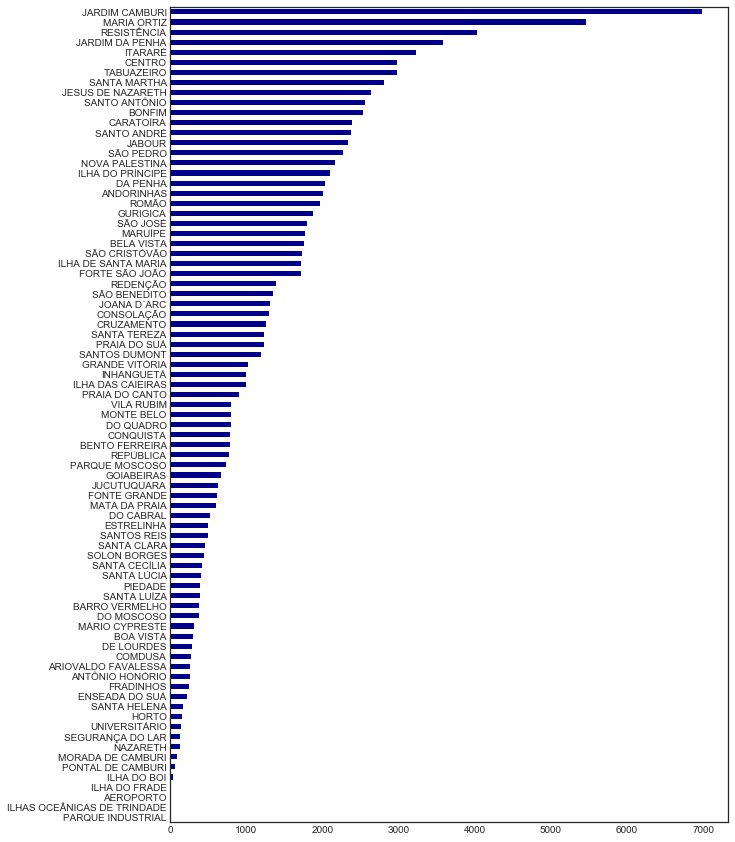

In [90]:
fig, ax = plt.subplots(figsize = (10, 15))
df['Neighborhood'].value_counts().sort_values().plot(kind = 'barh', color = 'darkblue');

#### SMS Received and No Shows

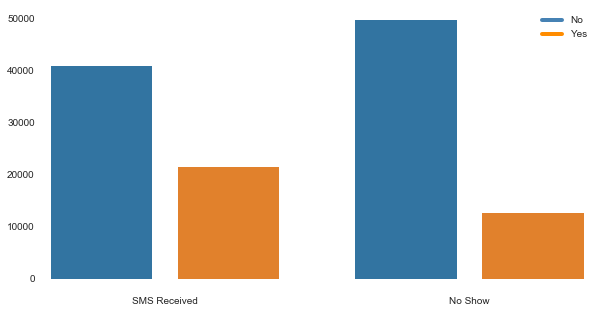

In [97]:
# Plot binary appointment characteristics
fields = ['SMSReceived', 'NoShow']
xlabels = ['SMS Received', 'No Show']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    ax.set(xticklabels=['', ''])
    ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [98]:
# Proportion of sms received
df['SMSReceived'].mean()

0.3251475889708555

In [99]:
# Proportion of no shows
df['NoShow'].mean()

0.19689007200180741